# $Evaluate$ $Zillow$

## imports

In [22]:
import numpy as np
import pandas as pd
from scipy import stats
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression

from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.feature_selection import f_regression 

from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt
import wrangle as w

### 1. Load your zillow dataset.

In [2]:
# wrangel zillow data
df = w.wrangle_single_family_residential()

### handle outliers
train = w.handle_outliers(train)

In [3]:
df = w.remove_outliers(df,['squarefeet','taxamount','tax_value','bathroom','bedroom'])

In [4]:
df.shape

(2046943, 7)

In [14]:
1-(2046943/2140235)
# outliers removed are about 4.4% of the data

0.043589605814314814

In [19]:
train.shape

(1146287, 8)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1146287 entries, 1754169 to 1513164
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   bedroom     1146287 non-null  float64
 1   bathroom    1146287 non-null  float64
 2   squarefeet  1146287 non-null  float64
 3   tax_value   1146287 non-null  float64
 4   yearbuilt   1146287 non-null  float64
 5   taxamount   1146287 non-null  float64
 6   fips        1146287 non-null  float64
 7   age         1146287 non-null  float64
dtypes: float64(8)
memory usage: 78.7 MB


In [21]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroom,1146287.0,3.260069,0.867203,1.00,3.000,3.00,4.000,6.0
bathroom,1146287.0,2.147012,0.817398,0.00,2.000,2.00,3.000,5.5
squarefeet,1146287.0,1756.303304,708.028175,1.00,1246.000,1594.00,2119.000,5057.0
tax_value,1146287.0,374963.054685,264586.835940,22.00,183509.000,316213.00,500000.000,1460504.0
yearbuilt,1146287.0,1960.392843,21.584448,1801.00,1949.000,1958.00,1974.000,2016.0
taxamount,1146287.0,4630.846192,3048.304862,20.24,2477.285,3974.58,6030.335,17607.6
fips,1146287.0,6048.401857,20.494672,6037.00,6037.000,6037.00,6059.000,6111.0
age,1146287.0,56.607157,21.584448,1.00,43.000,59.00,68.000,216.0


### 2. Fit a linear regression model (ordinary least squares) and compute yhat, predictions of taxvaluedollarcnt using only calculatedfinishedsqft.

In [23]:
#drop extra columns
train = train.drop(columns=['bedroom','bathroom',
                    'yearbuilt','taxamount', 'fips')

In [24]:
train.head()

,squarefeet,tax_value
1754169,4044.0,1139088.0
1221606,2378.0,418000.0
1264841,1242.0,282308.0
4661,1569.0,62828.0
1080763,1006.0,536000.0


In [25]:
# create the scaler and fit/transform squarefeet
mms = MinMaxScaler()

train['squarefeet'] = mms.fit_transform(train[['squarefeet']])

In [26]:
train.head()

,squarefeet,tax_value
1754169,0.799644,1139088.0
1221606,0.470134,418000.0
1264841,0.245451,282308.0
4661,0.310127,62828.0
1080763,0.198774,536000.0


In [29]:
#split into my X_train and y_train
X_train = train[['squarefeet']]
y_train = train.tax_value

X_validate = validate[['squarefeet']]
y_validate = validate.tax_value

X_test = test[['squarefeet']]
y_test = test.tax_value

In [34]:
X_train.head()

,squarefeet
1754169,0.799644
1221606,0.470134
1264841,0.245451
4661,0.310127
1080763,0.198774


In [35]:
y_train.head()

1754169    1139088.0
1221606     418000.0
1264841     282308.0
4661         62828.0
1080763     536000.0
Name: tax_value, dtype: float64

In [37]:
model = LinearRegression().fit(X_train, y_train)
predictions = model.predict(X_train)
predictions

array([836322.73753838, 500340.59757615, 271243.53215172, ...,
       187752.17204106, 453754.83867382, 227884.49248072])

In [38]:
train['yhat'] = predictions

In [39]:
train.head()

,squarefeet,tax_value,yhat
1754169,0.799644,1139088.0,836322.737538
1221606,0.470134,418000.0,500340.597576
1264841,0.245451,282308.0,271243.532152
4661,0.310127,62828.0,337189.606442
1080763,0.198774,536000.0,223649.423490


### 3. Plot the residuals for the linear regression model that you made.

In [41]:
train['residuals'] = train.tax_value - train.yhat

In [42]:
train.head()

,squarefeet,tax_value,yhat,residuals
1754169,0.799644,1139088.0,836322.737538,302765.262462
1221606,0.470134,418000.0,500340.597576,-82340.597576
1264841,0.245451,282308.0,271243.532152,11064.467848
4661,0.310127,62828.0,337189.606442,-274361.606442
1080763,0.198774,536000.0,223649.423490,312350.576510


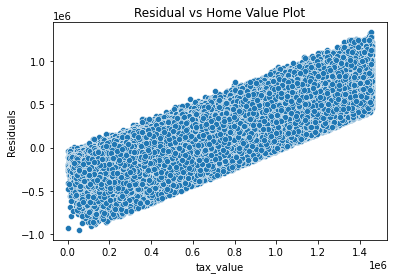

In [45]:
sns.scatterplot(data=train, x = 'tax_value', y = 'residuals')

plt.xlabel('tax_value')
plt.ylabel('Residuals')
plt.title('Residual vs Home Value Plot')
plt.show()

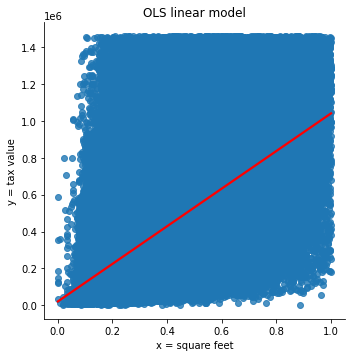

In [49]:
# visualize the line of best fit from OLS linear model

#scatter is my actuals
#plt.scatter(train.squarefeet, train.tax_value)

#lineplot is my regression line
#plt.plot(train.squarefeet, train.tax_value)
sns.lmplot(data=train, x='squarefeet', y='tax_value', line_kws={'color':'red'})
plt.xlabel('x = square feet')
plt.ylabel('y = tax value')
plt.title('OLS linear model')
plt.show()

In [ ]:
# visualize the line of best fit from OLS linear model

#scatter is my actuals
plt.scatter(lr_model.squarefeet, lr_model.tax_value)

#lineplot is my regression line
plt.plot(lr_model.squarefeet, lr_model.yhat, color ='red' )

plt.xlabel('x = squarefeet')
plt.ylabel('y = tax_value')
plt.title('OLS linear model')
plt.show()

### 4. Calculate the sum of squared errors, explained sum of squares, total sum of squares, mean squared error, and root mean squared error for your model.

### MSE - mean squared error

In [50]:
MSE = mean_squared_error(train.tax_value, train.yhat)
MSE

49617735218.69385

### SSE - Sum of squared errors

In [52]:
SSE = MSE * len(train)
SSE

5.687616485063091e+16

### RMSE - root mean squared error

In [53]:
RMSE = MSE ** .5
RMSE

222750.3876959451

### ESS - explained sum of squared

In [55]:
ESS = ((train.yhat - train.tax_value.mean())**2).sum()
ESS

2.3370954961164796e+16

### TSS - total sum squared

In [56]:
TSS = ESS + SSE
TSS

8.024711981179571e+16

### 5. Calculate the sum of squared errors, mean squared error, and root mean squared error for the baseline model (i.e. a model that always predicts the average taxvaluedollarcnt amount).

In [57]:
# establish baseline
baseline = train.tax_value.mean()
train['baseline']=baseline
baseline

374963.0546852577

In [58]:
train.head()

,squarefeet,tax_value,yhat,residuals,baseline
1754169,0.799644,1139088.0,836322.737538,302765.262462,374963.054685
1221606,0.470134,418000.0,500340.597576,-82340.597576,374963.054685
1264841,0.245451,282308.0,271243.532152,11064.467848,374963.054685
4661,0.310127,62828.0,337189.606442,-274361.606442,374963.054685
1080763,0.198774,536000.0,223649.423490,312350.576510,374963.054685


### MSE

In [61]:
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
MSE_baseline

70006132680.37177

### SSE

In [62]:
SSE_baseline = MSE_baseline * len(train)
SSE_baseline

8.024711981178531e+16

### RSME

In [63]:
RMSE_baseline = MSE_baseline**.5
RMSE_baseline

264586.7205291523

### Evaluation DataFrame

In [67]:
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
df_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])

df_eval['model_error'] = np.array([SSE, MSE, RMSE])
df_baseline_eval['baseline_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])

df_eval.
print(df_eval)
print(df_baseline_eval)


  metric   model_error
0    SSE  5.687616e+16
1    MSE  4.961774e+10
2   RMSE  2.227504e+05
          metric  baseline_error
0   SSE_baseline    8.024712e+16
1   MSE_baseline    7.000613e+10
2  RMSE_baseline    2.645867e+05


In [74]:
eval_df = pd.concat([df_eval, df_baseline_eval], axis=1)
eval_df

,metric,model_error,metric,baseline_error
0,SSE,5.687616e+16,SSE_baseline,8.024712e+16
1,MSE,4.961774e+10,MSE_baseline,7.000613e+10
2,RMSE,2.227504e+05,RMSE_baseline,2.645867e+05


In [77]:
eval_df['error_delta'] = df_eval.model_error - df_baseline_eval.baseline_error


In [78]:
eval_df

,metric,model_error,metric,baseline_error,error_delta
0,SSE,5.687616e+16,SSE_baseline,8.024712e+16,-2.337095e+16
1,MSE,4.961774e+10,MSE_baseline,7.000613e+10,-2.038840e+10
2,RMSE,2.227504e+05,RMSE_baseline,2.645867e+05,-4.183633e+04


## Example of definition with dataframe and columns

``` python

def y (df, feature, target):
    new_df = pd.DataFrame()
    baseline = df[feature].mean()
    new_df[feature]=df[feature]
    new_df[target]=df[target]
    return new_df
```

### 6. Write python code that compares the sum of squared errors for your model against the sum of squared errors for the baseline model and outputs whether or not your model performs better than the baseline model.

In [66]:
if SSE < SSE_baseline:
    print('My OSL model performs better than baseline')
else:
    print('My OSL model performs worse than baseline. :( )')

My OSL model performs better than baseline


### 7. What is the amount of variance explained in your model?

In [79]:
# calculated
R2 = ESS/TSS
print('R-squared = ',round(R2,3))
print("Percent of variance in y explained by x = ", round(R2*100,1), "%")


R-squared =  0.291
Percent of variance in y explained by x =  29.1 %


In [82]:
# Using sklearn
r2_score(train.tax_value, train.yhat)

0.291237305662428

In [84]:
#  Using sklearn.metrics.explained_variance_score

evs = explained_variance_score(train.tax_value, train.yhat)
print('Explained Variance = ', round(evs,3))

Explained Variance =  0.291


### 8. Is your model better than the baseline model?

In [86]:
#Difference in RMSE
RMSE_baseline-RMSE

41836.33283320721

### 9. Create a file named evaluate.py that contains the following functions.

* plot_residuals(y, yhat): creates a residual plot
* regression_errors(y, yhat): returns the following values:
    * sum of squared errors (SSE)
    * explained sum of squares (ESS)
    * total sum of squares (TSS)
    * mean squared error (MSE)
    * root mean squared error (RMSE)
* baseline_mean_errors(y): computes the SSE, MSE, and RMSE for the baseline model
* better_than_baseline(y, yhat): returns true if your model performs better than the baseline, otherwise false


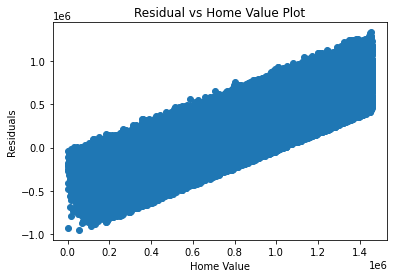

In [87]:
def plot_residuals(y, yhat):
    residuals = y - yhat
    
    plt.scatter(x=y, y=residuals)
    plt.xlabel('Home Value')
    plt.ylabel('Residuals')
    plt.title('Residual vs Home Value Plot')
    plt.show()
    
plot_residuals(train.tax_value, train.yhat)

In [89]:
def regression_errors(y, yhat):
    MSE = mean_squared_error(y, yhat)
    SSE = MSE * len(y)
    RMSE = MSE**.5
    
    ESS = ((yhat - y.mean())**2).sum()
    TSS = ESS + SSE
    
    return f'SSE = {SSE}', f'ESS = {ESS}', f'TSS = {TSS}', f'MSE = {MSE}', f'RMSE = {RMSE}'

regression_errors(train.tax_value, train.yhat)


('SSE = 5.687616485063091e+16',
 'ESS = 2.3370954961164796e+16',
 'TSS = 8.024711981179571e+16',
 'MSE = 49617735218.69385',
 'RMSE = 222750.3876959451')

In [92]:
def baseline_mean_errors(y):
    baseline = np.repeat(y.mean(), len(y))
    
    MSE = mean_squared_error(y, baseline)
    SSE = MSE * len(y)
    RMSE = MSE**.5
    
    return f'baseline SSE = {SSE}',f'baseline MSE = {MSE}', f'baseline RMSE = {RMSE}'

baseline_mean_errors(train.tax_value)


('baseline SSE = 8.024711981178531e+16',
 'baseline MSE = 70006132680.37177',
 'baseline RMSE = 264586.7205291523')

In [94]:
def better_than_baseline(y, yhat):
    SSE, ESS, TSS, MSE, RMSE = regression_errors(y, yhat)
    
    SSE_baseline, MSE_baseline, RMSE_baseline = baseline_mean_errors(y)
    
    if SSE < SSE_baseline:
        print('My OSL model performs better than baseline')
    else:
        print('My OSL model performs worse than baseline. :( )')
        
better_than_baseline(train.tax_value, train.yhat)

My OSL model performs better than baseline
